In [1]:
### imports

import keras
import numpy as np
import pandas as pd
from scipy import stats
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import uproot
import awkward as ak
from tqdm.notebook import tqdm

In [2]:
# latex settings block

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.numpoints": 1,
    "axes.linewidth": 2,
    "legend.title_fontsize": 18,
    "axes.labelsize": 18,
    "legend.fontsize": 16
})

In [3]:
with np.load("root_files/features_and_labels_train.npz") as file:
    feature_array = file['features']
    label_array = file['labels']

In [4]:
# take the feature labels out of a root file
with uproot.open(f"root_files/ntuple_merged_0.root:deepntuplizer/tree") as tree:
    features = ['fj_jetNTracks','fj_nSV']+[x for x in tree.keys() if x[:6]=='fj_tau' or x[:8]=='fj_track'] 

# 2 labels: QCD or Hbb. Logical "and" of labels is used.
labels = ['fj_isQCD*sample_isQCD',
          'fj_isH*fj_isBB']

nfeatures = len(features)
nlabels = len(labels)

In [5]:
df = pd.DataFrame(feature_array, columns=features)
bkg = df[label_array[:,0]==1]
sig = df[label_array[:,1]==1]

In [6]:
with np.load("root_files/features_and_labels_test.npz") as file:
    feature_array_test = file['features']
    label_array_test = file['labels']

In [7]:
del feature_array, label_array

In [8]:
df_test = pd.DataFrame(feature_array_test, columns=features)
bkg_test = df_test[label_array_test[:,0]==1]
sig_test = df_test[label_array_test[:,1]==1]

In [9]:
del feature_array_test, label_array_test

In [10]:
sig_train_out = sig
bkg_train_out = bkg
sig_test_out = sig_test
bkg_test_out = bkg_test

In [11]:
print(bkg.shape)
print(bkg_train_out.shape)
print(bkg_test.shape)
print(bkg_test_out.shape)

(13234082, 31)
(13234082, 31)
(1467277, 31)
(1467277, 31)


In [12]:
del bkg, sig, bkg_test, sig_test, df

In [13]:
bkg_train_out = bkg_train_out.sample(len(sig_train_out)).reset_index(drop=True)
bkg_test_out = bkg_test_out.sample(len(sig_test_out)).reset_index(drop=True)

In [14]:
print(bkg_train_out.shape)
print(sig_train_out.shape)
print(bkg_test_out.shape)
print(sig_test_out.shape)

(2010784, 31)
(2010784, 31)
(222732, 31)
(222732, 31)


In [17]:
features

['fj_jetNTracks',
 'fj_nSV',
 'fj_tau0_trackEtaRel_0',
 'fj_tau0_trackEtaRel_1',
 'fj_tau0_trackEtaRel_2',
 'fj_tau1',
 'fj_tau1_trackEtaRel_0',
 'fj_tau1_trackEtaRel_1',
 'fj_tau1_trackEtaRel_2',
 'fj_tau2',
 'fj_tau21',
 'fj_tau3',
 'fj_tau32',
 'fj_tau_flightDistance2dSig_0',
 'fj_tau_flightDistance2dSig_1',
 'fj_tau_vertexDeltaR_0',
 'fj_tau_vertexEnergyRatio_0',
 'fj_tau_vertexEnergyRatio_1',
 'fj_tau_vertexMass_0',
 'fj_tau_vertexMass_1',
 'fj_trackSip2dSigAboveBottom_0',
 'fj_trackSip2dSigAboveBottom_1',
 'fj_trackSip2dSigAboveCharm_0',
 'fj_trackSipdSig_0',
 'fj_trackSipdSig_0_0',
 'fj_trackSipdSig_0_1',
 'fj_trackSipdSig_1',
 'fj_trackSipdSig_1_0',
 'fj_trackSipdSig_1_1',
 'fj_trackSipdSig_2',
 'fj_trackSipdSig_3']

  0%|          | 0/30 [00:00<?, ?it/s]

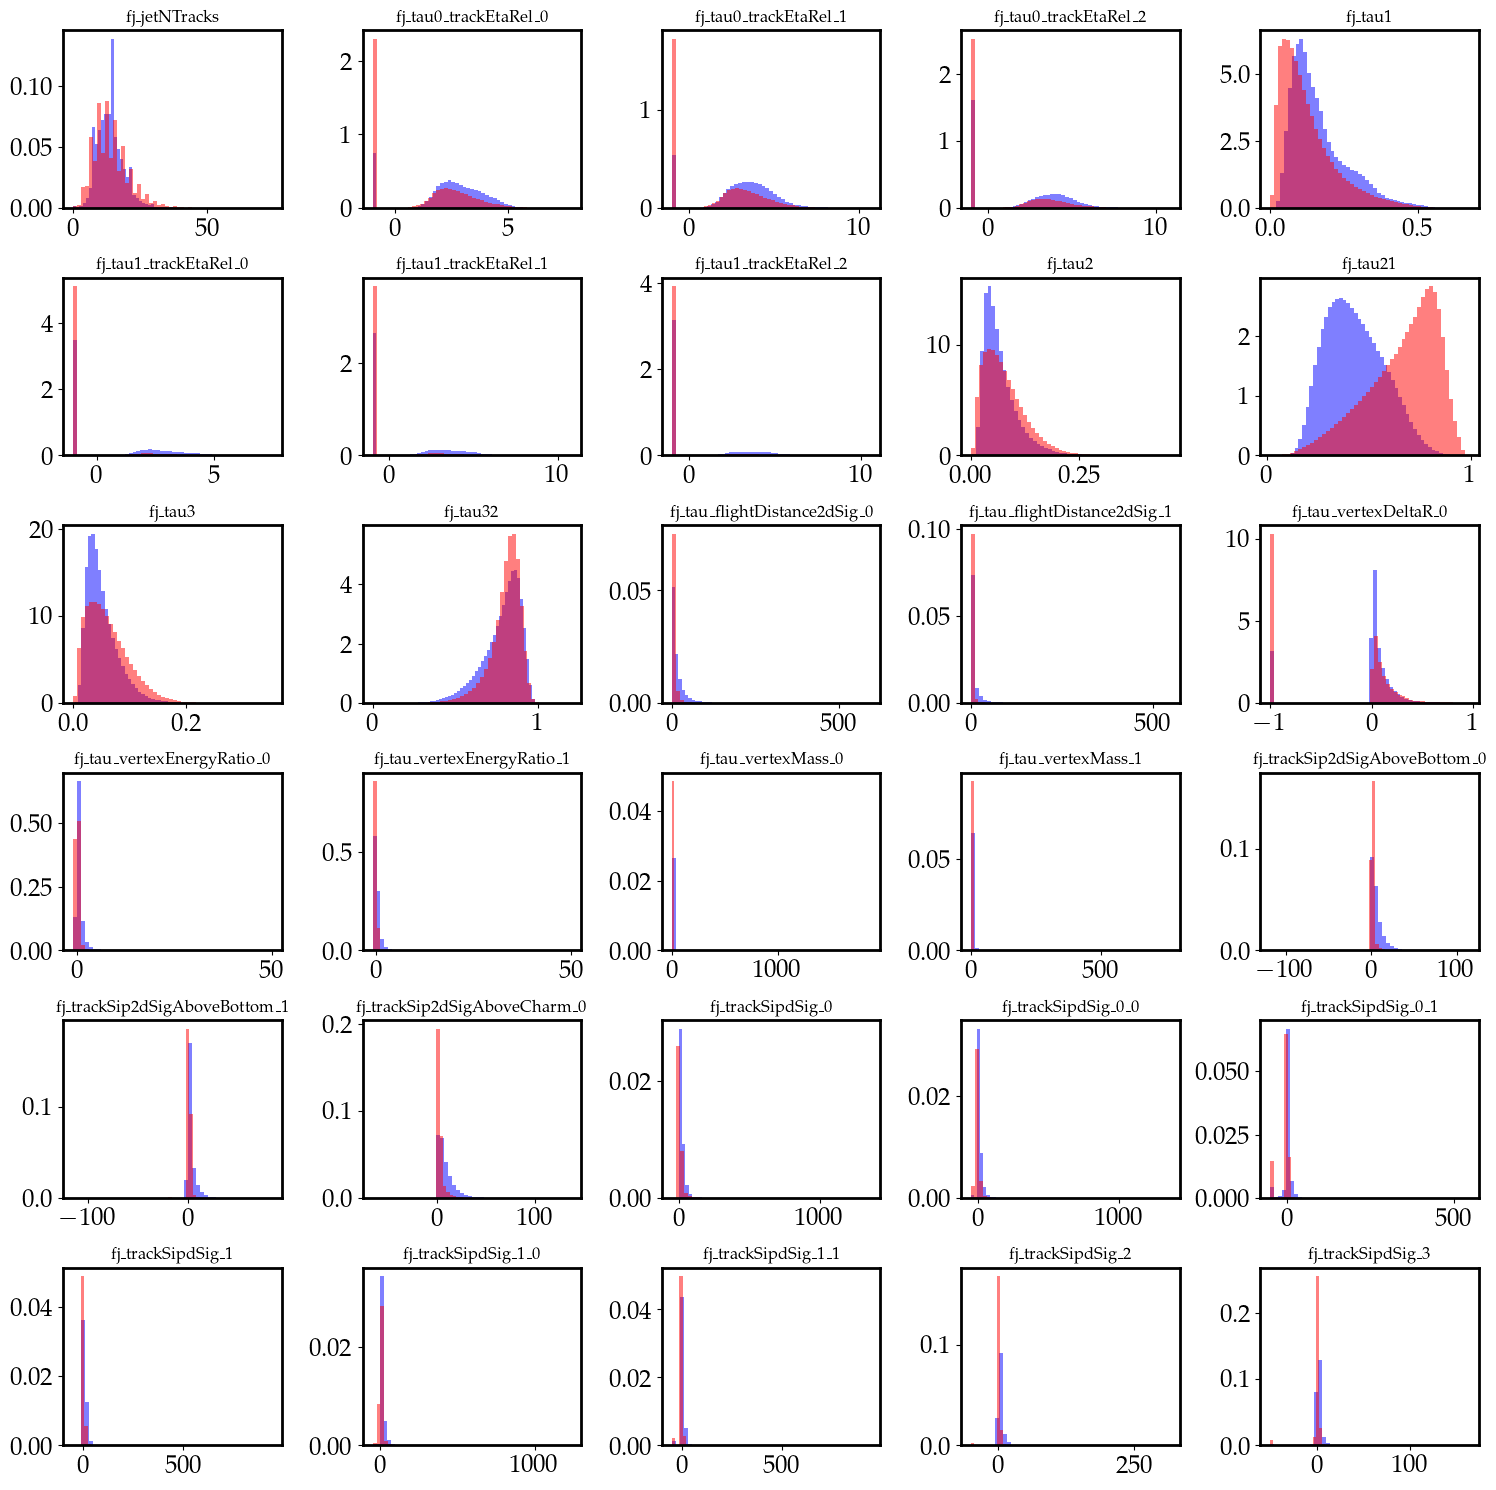

In [20]:
fig, axes = plt.subplots(6,5, figsize=(15,15))

for ax, label in tqdm(zip(axes.ravel(), sig_train_out.columns.drop('fj_nSV')), total = 30):
    ax.hist(sig_train_out[label],density=True,color='b',alpha=0.5,bins=50)
    ax.hist(bkg_train_out[label],density=True,color='r',alpha=0.5,bins=50)
    ax.set_title(label)

plt.tight_layout()
plt.show()

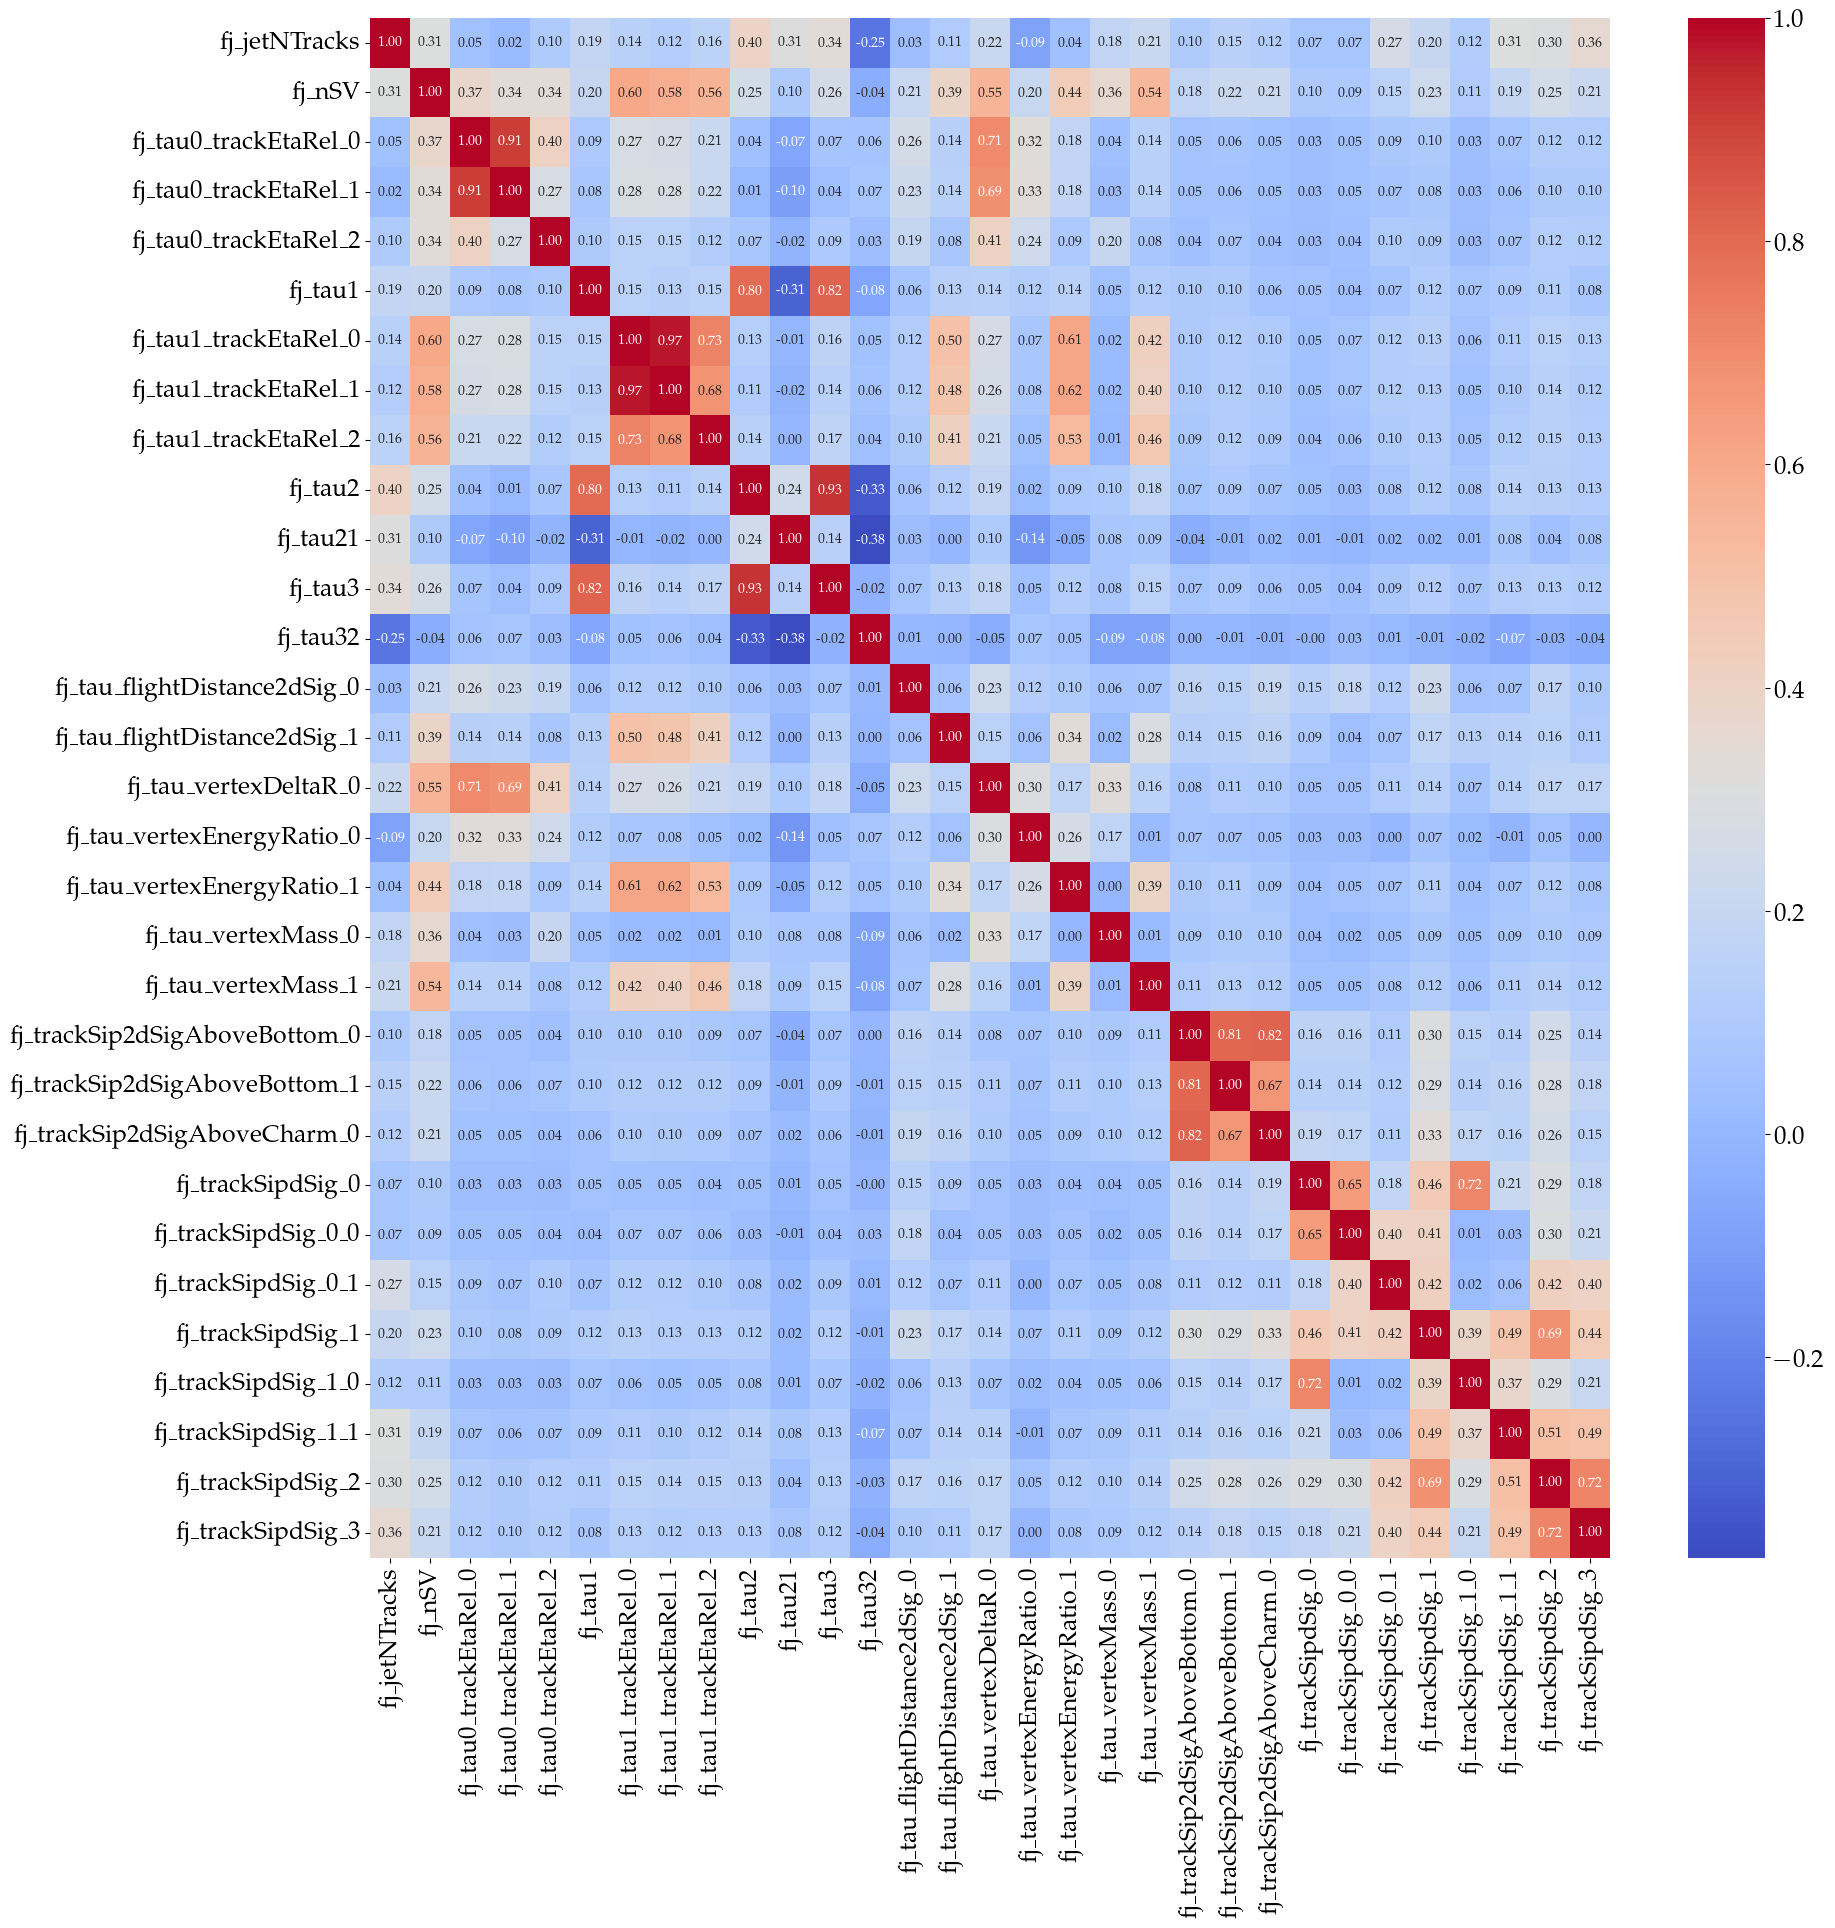

In [21]:
plt.figure(figsize=(20,20))
sns.heatmap(sig_train_out.corr(), cmap='coolwarm',annot=True, fmt='.2f')
plt.show()

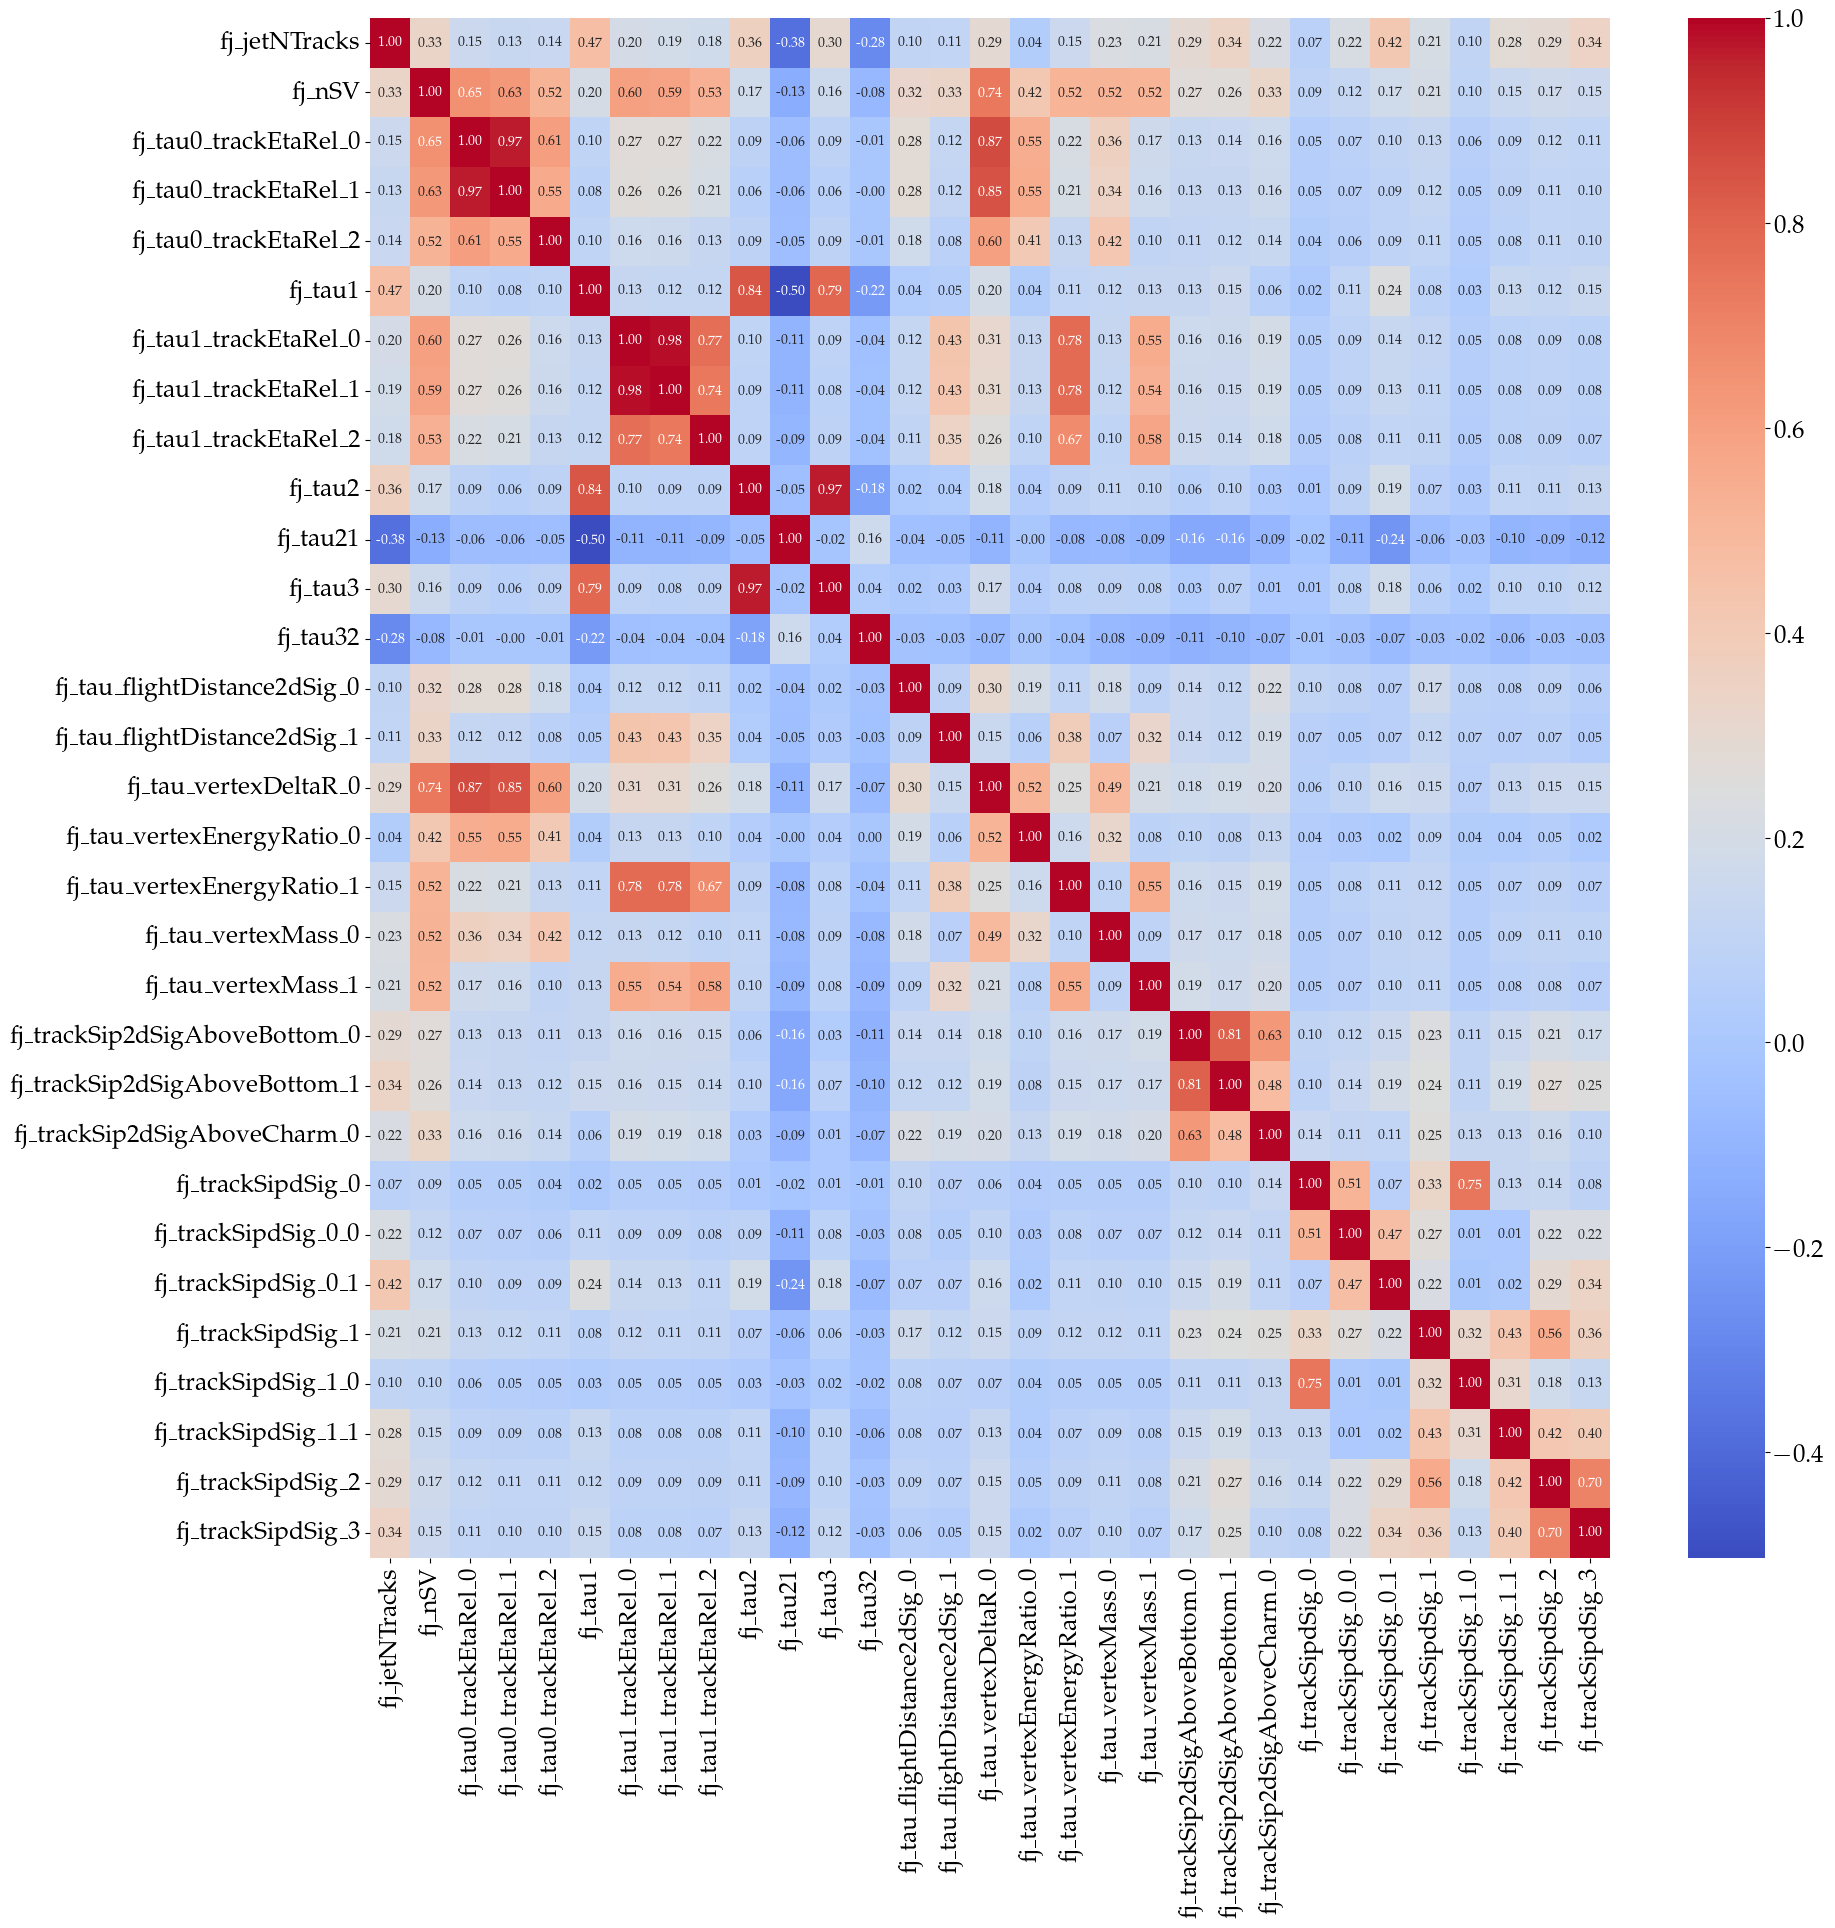

In [22]:
plt.figure(figsize=(20,20))
sns.heatmap(bkg_train_out.corr(), cmap='coolwarm',annot=True, fmt='.2f')
plt.show()

In [23]:
hbb = np.concatenate((np.ones(len(sig_train_out)),np.zeros(len(bkg_train_out))), axis=None)
QCD = np.concatenate((np.zeros(len(sig_train_out)),np.ones(len(bkg_train_out))), axis=None)
traindata = pd.concat([sig_train_out, bkg_train_out])
traindata['hbb'] = hbb
traindata['QCD'] = QCD

train = traindata.sample(frac=1).reset_index(drop=True)
X_train = train.iloc[:,:-2]
y_train = train.iloc[:,-2:]

In [24]:
del traindata

In [25]:
hbb = np.concatenate((np.ones(len(sig_test_out)),np.zeros(len(bkg_test_out))), axis=None)
QCD = np.concatenate((np.zeros(len(sig_test_out)),np.ones(len(bkg_test_out))), axis=None)
testdata = pd.concat([sig_test_out, bkg_test_out])
testdata['hbb'] = hbb
testdata['QCD'] = QCD

test = testdata.sample(frac=1).reset_index(drop=True)
X_test = test.iloc[:,:-2]
y_test = test.iloc[:,-2:]

In [26]:
del testdata

In [27]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test)

In [28]:
eigenvalues, eigenvectors = np.linalg.eig(X_train.cov())

In [29]:
idx = eigenvalues.argsort()[::-1]   
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

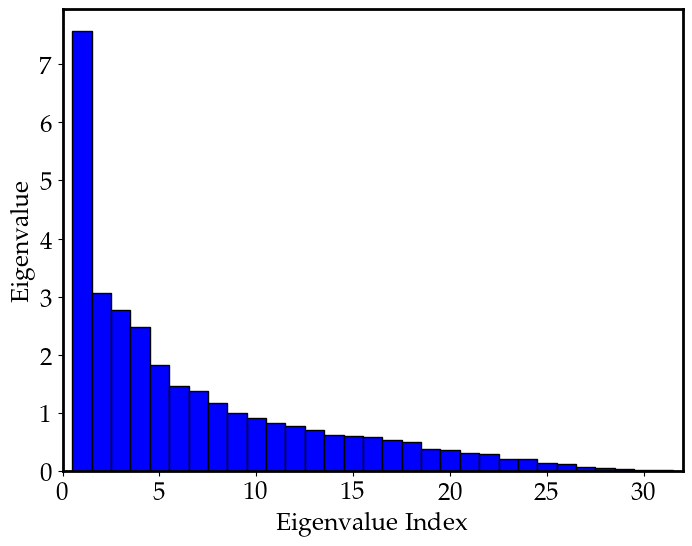

In [30]:
plt.figure(figsize=(8,6))
x = np.arange(1,32)
plt.xlim(0,32)
plt.bar(x,eigenvalues,color='b',width=1,edgecolor='k')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.show()

In [31]:
pca = PCA()
pca.fit(X_train)
print(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_))
print(pca.singular_values_)

[0.24418649 0.09873382 0.08927868 0.08018265 0.05864969 0.04730354
 0.04432005 0.03767531 0.03215013 0.02945496 0.02657301 0.02484857
 0.02256846 0.02016082 0.01956217 0.01888561 0.01727806 0.01600588
 0.01238789 0.01193352 0.01016721 0.00970744 0.00693224 0.00669307
 0.00456962 0.00384314 0.00213747 0.0014414  0.00139366 0.0005839
 0.00039153]
[0.24418649 0.34292031 0.432199   0.51238165 0.57103135 0.61833489
 0.66265494 0.70033025 0.73248038 0.76193534 0.78850835 0.81335692
 0.83592538 0.8560862  0.87564836 0.89453398 0.91181203 0.92781791
 0.94020581 0.95213932 0.96230653 0.97201397 0.97894621 0.98563929
 0.9902089  0.99405205 0.99618951 0.99763091 0.99902457 0.99960847
 1.        ]
[5517.46230035 3508.41959889 3336.20283828 3161.68621564 2704.02954352
 2428.42886551 2350.59966542 2167.23989427 2002.02682109 1916.27476951
 1820.1155063  1760.06718282 1677.37252667 1585.37720199 1561.66196713
 1534.41952248 1467.66186216 1412.59716694 1242.73136399 1219.72744864
 1125.84728357 1100.0

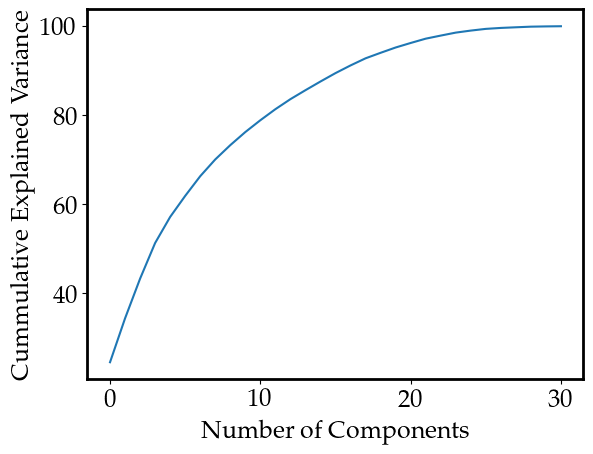

In [32]:
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel('Number of Components')
plt.ylabel('Cummulative Explained Variance')
plt.show()

In [33]:
X_train_final = pd.DataFrame(pca.transform(X_train)).iloc[:,:10]
X_test_final =  pd.DataFrame(pca.transform(X_test)).iloc[:,:10]

In [34]:
def KL(feature1 ,feature2 , bins = 100, eps = 1e-8):
    low, high = (np.min([np.min(feature1),np.min(feature2)]), np.max([np.max(feature1),np.max(feature2)]))
    pk, bins = np.histogram(feature1, bins=bins, range=(low,high))
    qk, bins = np.histogram(feature2, bins=bins, range=(low,high))
    pk = pk + eps
    qk = qk + eps
    D1 = stats.entropy(pk, qk)
    D2 = stats.entropy(qk, pk)
    divergence = D1 + D2
    return divergence

In [35]:
div = []
for i in tqdm(features):
    divergence = KL(sig_train_out[i], bkg_train_out[i])
    div.append(divergence)
divergences = pd.Series(div, index=features).sort_values(ascending=False)
print(divergences)

  0%|          | 0/31 [00:00<?, ?it/s]

fj_tau21                         2.232626
fj_trackSip2dSigAboveBottom_0    1.360595
fj_trackSip2dSigAboveCharm_0     1.170482
fj_trackSipdSig_0                1.048104
fj_trackSip2dSigAboveBottom_1    1.021602
fj_tau_flightDistance2dSig_0     0.902321
fj_trackSipdSig_0_0              0.824575
fj_tau_vertexEnergyRatio_0       0.757241
fj_nSV                           0.704332
fj_tau_vertexDeltaR_0            0.601396
fj_trackSipdSig_0_1              0.599137
fj_tau_vertexEnergyRatio_1       0.595875
fj_trackSipdSig_1                0.587771
fj_tau1                          0.559379
fj_trackSipdSig_2                0.554675
fj_tau0_trackEtaRel_1            0.491156
fj_tau0_trackEtaRel_0            0.490445
fj_tau_flightDistance2dSig_1     0.450147
fj_tau1_trackEtaRel_1            0.441103
fj_tau1_trackEtaRel_0            0.439180
fj_trackSipdSig_3                0.364358
fj_tau1_trackEtaRel_2            0.313764
fj_trackSipdSig_1_0              0.311904
fj_tau0_trackEtaRel_2            0

In [36]:
def make_ks_plot(y_train, train_proba, y_test, test_proba, bins=30, fig_sz=(10, 8)):
    '''
    OUTPUT: outputs KS test/train overtraining plots for classifier output
    INPUTS:
        y_train - Series with outputs of model
        train_proba - np.ndarray from sklearn predict_proba(). Same shape as y_train. 0-1 probabilities from model.
        y_test - Series with outputs of model
        test_proba - np.ndarray from sklearn predict_proba(). Same shape as y_test. 0-1 probabilities from model.
        bins - number of bins for viz. Default 30.
        fig_sz - change to True in order to get larger outputs. Default False.
    '''

    train = pd.DataFrame(y_train, columns=["label"])
    test = pd.DataFrame(y_test, columns=["label"])
    train["probability"] = train_proba
    test["probability"] = test_proba
    
    decisions = []
    for df in [train, test]:
        d1 = df['probability'][df["label"] == 1]
        d2 = df['probability'][df["label"] == 0]
        decisions += [d1, d2]

    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (0,1)

    fig = plt.figure(figsize=fig_sz)
    
    train_pos = plt.hist(decisions[0],
         color='b', alpha=0.5, range=low_high, bins=bins,
         histtype='stepfilled', density=True,
         label='Signal (test)')

    train_neg = plt.hist(decisions[1],
         color='r', alpha=0.5, range=low_high, bins=bins,
         histtype='stepfilled', density=True,
         label='Background (test)')

    hist, bins = np.histogram(decisions[2],
                          bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    test_pos = plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='Signal (train)')

    hist, bins = np.histogram(decisions[3],
                          bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    test_neg = plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='Background (train)')

    # get the KS score
    ks = stats.ks_2samp(decisions[0], decisions[2])

    plt.xlabel("Classifier Output", fontsize=12)
    plt.ylabel("Arbitrary Normalized Units", fontsize=12)

    plt.xlim(0, 1)
    plt.plot([], [], ' ', label='KS Statistic (p-value): '+str(round(ks[0],3))+' ('+str(round(ks[1],3))+')')
    plt.legend(loc='upper center', fontsize=12)
    plt.close()
    return fig

In [37]:
# build a simple neural network in keras

keras_model = keras.Sequential()
keras_model.add(Dense(units=32,activation='relu',input_dim=10))
keras_model.add(Dense(units=32,activation='relu'))
keras_model.add(Dense(units=2,activation='softmax'))
keras_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(keras_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                352       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1,474
Trainable params: 1,474
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
# fit keras model
keras_model.fit(X_train_final.to_numpy(), y_train.to_numpy(), batch_size=2**14, 
                epochs=100, validation_split=0.2)

Epoch 1/100
  1/197 [..............................] - ETA: 33s - loss: 0.8721 - accuracy: 0.3505

2022-10-27 17:19:34.028681: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


197/197 [==============================] - 1s 4ms/step - loss: 0.3996 - accuracy: 0.8162 - val_loss: 0.3132 - val_accuracy: 0.8666
Epoch 2/100
197/197 [==============================] - 1s 4ms/step - loss: 0.2993 - accuracy: 0.8738 - val_loss: 0.2900 - val_accuracy: 0.8783
Epoch 3/100
197/197 [==============================] - 1s 4ms/step - loss: 0.2861 - accuracy: 0.8802 - val_loss: 0.2821 - val_accuracy: 0.8824
Epoch 4/100
197/197 [==============================] - 1s 4ms/step - loss: 0.2806 - accuracy: 0.8828 - val_loss: 0.2783 - val_accuracy: 0.8840
Epoch 5/100
197/197 [==============================] - 1s 4ms/step - loss: 0.2775 - accuracy: 0.8843 - val_loss: 0.2756 - val_accuracy: 0.8852
Epoch 6/100
197/197 [==============================] - 1s 4ms/step - loss: 0.2752 - accuracy: 0.8852 - val_loss: 0.2737 - val_accuracy: 0.8860
Epoch 7/100
197/197 [==============================] - 1s 4ms/step - loss: 0.2736 - accuracy: 0.8859 - val_loss: 0.2722 - val_accuracy: 0.8865
Epoch 8/100

197/197 [==============================] - 1s 6ms/step - loss: 0.2608 - accuracy: 0.8914 - val_loss: 0.2606 - val_accuracy: 0.8917
Epoch 59/100
197/197 [==============================] - 1s 6ms/step - loss: 0.2606 - accuracy: 0.8915 - val_loss: 0.2602 - val_accuracy: 0.8917
Epoch 60/100
197/197 [==============================] - 1s 6ms/step - loss: 0.2606 - accuracy: 0.8914 - val_loss: 0.2602 - val_accuracy: 0.8919
Epoch 61/100
197/197 [==============================] - 1s 6ms/step - loss: 0.2606 - accuracy: 0.8915 - val_loss: 0.2603 - val_accuracy: 0.8917
Epoch 62/100
197/197 [==============================] - 1s 6ms/step - loss: 0.2605 - accuracy: 0.8915 - val_loss: 0.2601 - val_accuracy: 0.8918
Epoch 63/100
197/197 [==============================] - 1s 6ms/step - loss: 0.2604 - accuracy: 0.8916 - val_loss: 0.2602 - val_accuracy: 0.8918
Epoch 64/100
197/197 [==============================] - 1s 6ms/step - loss: 0.2604 - accuracy: 0.8915 - val_loss: 0.2601 - val_accuracy: 0.8918
Epoch

In [39]:
# run model inference on test data set
predict_array_train = keras_model.predict(X_train_final)
predict_array_test = keras_model.predict(X_test_final)

13921/13921 [==============================] - 4s 276us/step


In [48]:
# create ROC curve
fpr, tpr, threshold = roc_curve(y_test.to_numpy()[:,0], predict_array_test[:,0])

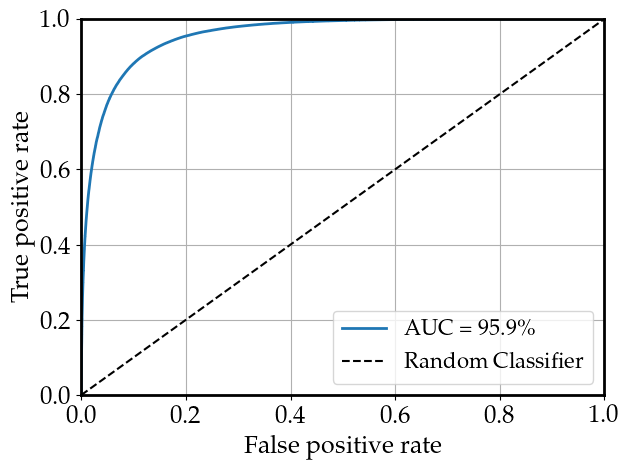

In [49]:
# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('plots/ROC.pdf')
plt.show()

In [42]:
fig = make_ks_plot(y_train.to_numpy()[:,0], predict_array_train[:,0], y_test.to_numpy()[:,0], predict_array_test[:,0])
fig.savefig('plots/KS.pdf')

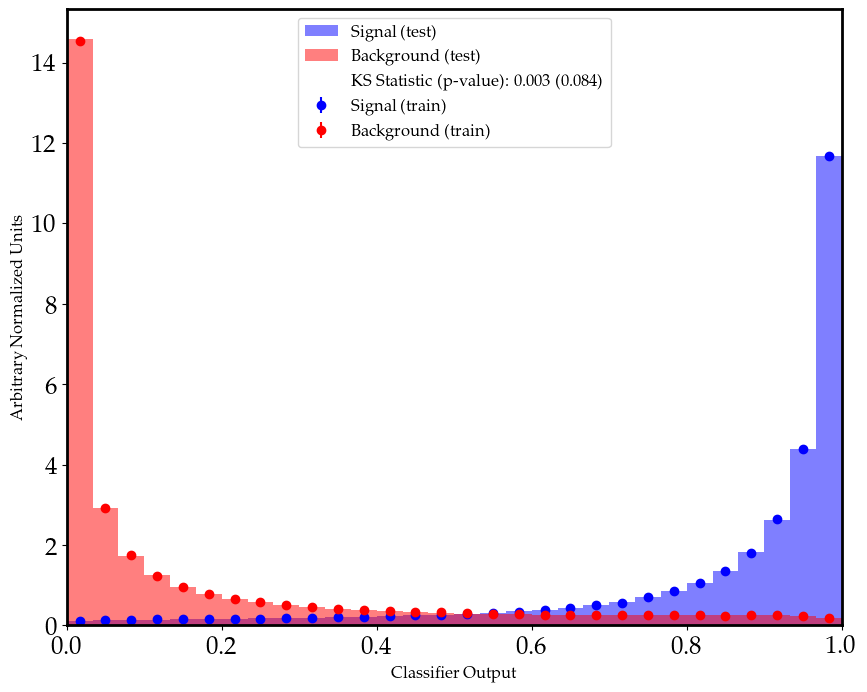

In [43]:
fig